# Fitting interaction parameters for mixtures

Available optimizations functions:
- [Quadratic mixing rule](#qmr)
- [NRTL](#nrtl)
- [Wilson](#wilson)
- [Redlich-Kister Expansion](#redlich-kister)
- [UNIQUAC](#uniquac)
- [$k_{ij}$ for Wong-Sandler](#wongsandler)

---
Let's call $\underline{\xi}$ the optimization parameters of a mixture. In order to optimize them, you need to provide experimental phase equilibria data. This can include VLE, LLE and VLLE data. The objective function used for each equilibria type are shown below:


### Vapor-Liquid Equilibria Data


$$ OF_{VLE}(\underline{\xi}) = w_y \sum_{j=1}^{Np} \left[ \sum_{i=1}^c (y_{i,j}^{cal} - y_{i,j}^{exp})^2 \right] +  w_P \sum_{j=1}^{Np} \left[ \frac{P_{j}^{cal} - P_{j}^{exp}}{P_{j}^{exp}} \right]^2$$

Where, $Np$ is the number of experimental data points, $y_i$ is the vapor molar fraction of the component $i$ and $P$ is the bubble pressure. The superscripts $cal$ and $exp$ refers to the computed and experimental values, respectively. Finally, $w_y$ is the weight for the vapor composition error and $w_P$ is the weight for the bubble pressure error.


### Liquid-Liquid Equilibria Data
$$ OF_{LLE}(\underline{\xi}) = w_x \sum_{j=1}^{Np} \sum_{i=1}^c  \left[x_{i,j} - x_{i,j}^{exp}\right]^2 +  w_w \sum_{j=1}^{Np} \sum_{i=1}^c \left[ w_{i,j} - w_{i,j}^{exp} \right]^2 $$

Where, $Np$ is the number of experimental data points, $x_i$ and $w_i$ are the molar fraction of the component $i$ on the liquids phases. The superscripts $cal$ and $exp$ refers to the computed and experimental values, respectively. Finally, $w_x$ and $w_w$ are the weights for the liquid 1 ($x$) and liquid 2 ($w$) composition error.


### Vapor-Liquid-Liquid Equilibria Data
$$ OF_{VLLE}(\underline{\xi}) = w_x \sum_{j=1}^{Np}  \sum_{i=1}^c  \left[x_{i,j}^{cal} - x_{i,j}^{exp}\right]^2 + w_w \sum_{j=1}^{Np}  \sum_{i=1}^c  \left[w_{i,j}^{cal} - w_{i,j}^{exp}\right]^2 +  w_y \sum_{j=1}^{Np}  \sum_{i=1}^c  \left[y_{i,j}^{cal} - y_{i,j}^{exp}\right]^2 + w_P \sum_{j=1}^{Np}  \left[ \frac{P_{j}^{cal}}{P_{j}^{exp}} - 1\right]^2 $$

Where, $Np$ is the number of experimental data points, $y_i$, $x_i$ and $w_i$ are the molar fraction of the component $i$ on the vapor and liquids phases, respectively. The superscripts $cal$ and $exp$ refers to the computed and experimental values, respectively. Finally, $w_x$ and $w_w$ are the weights for the liquid 1 ($x$) and liquid 2 ($w$) composition error, $w_y$ is the weight for vapor composition error and $w_P$ is weight for three phase equilibria pressure error.

If there is data for more than one equilibria type, the errors can be added accordinly. So the objective funcion becomes:

$$ OF(\underline{\xi}) =OF_{ELV}(\underline{\xi}) + OF_{ELL}(\underline{\xi}) + OF_{ELLV}(\underline{\xi})$$

---
This notebook has the purpose of showing examples of how to fit interaction parameters for binary mixtures using experimental equilibria data.

In [1]:
import numpy as np
from phasepy import component, mixture, prsveos

Now that the functions are available it is necessary to create the mixture.

In [2]:
water = component(name = 'Water', Tc = 647.13, Pc = 220.55, Zc = 0.229, Vc = 55.948, w = 0.344861,
                ksv = [ 0.87292043, -0.06844994],
                Ant =  [  11.72091059, 3852.20302815,  -44.10441047],
                cii = [ 1.16776082e-25, -4.76738739e-23,  1.79640647e-20],
                GC = {'H2O':1},
                ri=0.92, qi=1.4)

ethanol = component(name = 'Ethanol', Tc = 514.0, Pc = 61.37, Zc = 0.241, Vc = 168.0, w = 0.643558,
                ksv = [1.27092923, 0.0440421 ],
                Ant = [  12.26474221, 3851.89284329,  -36.99114863],
                cii = [ 2.35206942e-24, -1.32498074e-21,  2.31193555e-19],
                GC = {'CH3':1, 'CH2':1, 'OH(P)':1},
                ri=2.1055, qi=1.972)

mix = mixture(ethanol, water)

# or
mix = ethanol + water

Now the experimental equilibria data is read and a tuple is created. It includes the experimental liquid composition, vapor composition, equilibrium temperature and pressure. This is done with ```datavle = (Xexp, Yexp, Texp, Pexp)```

If the mixture exhibits other equilibria types you can supply this experimental data to the ``datalle`` or ``datavlle`` parameters.

- ``datalle``: (Xexp, Wexp, Texp, Pexp)
- ``datavlle``: (Xexp, Wexp, Yexp, Texp, Pexp)

You can specify the weights for each objetive function through the following parameters:

- ``weights_vle``: list or array_like, weights for the VLE objective function.
        - weights_vle[0] = weight for Y composition error, default to 1.
        - weights_vle[1] = weight for bubble pressure error, default to 1.
- ``weights_lle``: list or array_like, weights for the LLE objective function.
        - weights_lle[0] = weight for X (liquid 1) composition error, default to 1.
        - weights_lle[1] = weight for W (liquid 2) composition error, default to 1.
- ``weights_vlle``: list or array_like, weights for the VLLE objective function.
        - weights_vlle[0] = weight for X (liquid 1) composition error, default to 1.
        - weights_vlle[1] = weight for W (liquid 2) composition error, default to 1.
        - weights_vlle[2] = weight for Y (vapor) composition error, default to 1.
        - weights_vlle[3] = weight for equilibrium pressure error, default to 1.

Additionally, you can set options to the SciPy's ``minimize`` function using the ``minimize_options`` parameter.

In [3]:
#Vapor Liquid equilibria data obtanied from Rieder, Robert M. y A. Ralph Thompson (1949).
# «Vapor-Liquid Equilibria Measured by a GillespieStill - Ethyl Alcohol - Water System». 
#Ind. Eng. Chem. 41.12, 2905-2908.

#Saturation Pressure in bar
Pexp = np.array([1.013, 1.013, 1.013, 1.013, 1.013, 1.013, 1.013, 1.013, 1.013,
       1.013, 1.013, 1.013, 1.013, 1.013, 1.013, 1.013, 1.013, 1.013,
       1.013, 1.013, 1.013, 1.013, 1.013, 1.013, 1.013, 1.013, 1.013,
       1.013, 1.013, 1.013, 1.013, 1.013, 1.013, 1.013])

#Saturation temeprature in Kelvin
Texp = np.array([372.45, 370.05, 369.15, 369.15, 368.75, 367.95, 366.95, 366.65,
       366.05, 363.65, 363.65, 362.55, 361.55, 361.75, 360.35, 358.55,
       357.65, 357.15, 356.55, 356.15, 355.45, 355.15, 354.55, 354.65,
       354.35, 354.05, 353.65, 353.35, 353.15, 352.65, 351.95, 351.65,
       351.55, 351.45])

#Liquid fraction mole array
Xexp = np.array([[0.0028, 0.0118, 0.0137, 0.0144, 0.0176, 0.0222, 0.0246, 0.0302,
        0.0331, 0.0519, 0.053 , 0.0625, 0.0673, 0.0715, 0.0871, 0.126 ,
        0.143 , 0.172 , 0.206 , 0.21  , 0.255 , 0.284 , 0.321 , 0.324 ,
        0.345 , 0.405 , 0.43  , 0.449 , 0.506 , 0.545 , 0.663 , 0.735 ,
        0.804 , 0.917 ],
       [0.9972, 0.9882, 0.9863, 0.9856, 0.9824, 0.9778, 0.9754, 0.9698,
        0.9669, 0.9481, 0.947 , 0.9375, 0.9327, 0.9285, 0.9129, 0.874 ,
        0.857 , 0.828 , 0.794 , 0.79  , 0.745 , 0.716 , 0.679 , 0.676 ,
        0.655 , 0.595 , 0.57  , 0.551 , 0.494 , 0.455 , 0.337 , 0.265 ,
        0.196 , 0.083 ]])
#Vapor fraction mole array
Yexp = np.array([[0.032, 0.113, 0.157, 0.135, 0.156, 0.186, 0.212, 0.231, 0.248,
        0.318, 0.314, 0.339, 0.37 , 0.362, 0.406, 0.468, 0.487, 0.505,
        0.53 , 0.527, 0.552, 0.567, 0.586, 0.586, 0.591, 0.614, 0.626,
        0.633, 0.661, 0.673, 0.733, 0.776, 0.815, 0.906],
       [0.968, 0.887, 0.843, 0.865, 0.844, 0.814, 0.788, 0.769, 0.752,
        0.682, 0.686, 0.661, 0.63 , 0.638, 0.594, 0.532, 0.513, 0.495,
        0.47 , 0.473, 0.448, 0.433, 0.414, 0.414, 0.409, 0.386, 0.374,
        0.367, 0.339, 0.327, 0.267, 0.224, 0.185, 0.094]])

datavle = (Xexp, Yexp, Texp, Pexp)

<a id='qmr'></a>


## Fitting QMR mixing rule 

In this mixing rule the cohesive parameter of an cubic equation of state is computed as follows:

$$ a_{mix} = \sum_i \sum_j x_i x_j \sqrt{a_i a_j} (1-k_{ij}) $$

The ``kij`` value can be optimized from experimental data. As a scalar is been fitted, SciPy recommends giving a certain interval where the minimum could be found, the function ```fit_kij``` handles this optimization. 

**note:** you can supply the ``Kij`` correction matrix  using the ``mix.kij_cubic`` method.

In [4]:
from phasepy.fit import fit_kij

mixkij = mix.copy()
fit_kij((-0.15, -0.05), prsveos, mixkij, datavle)

     fun: 0.004884207696586613
    nfev: 17
     nit: 13
 success: True
       x: -0.10726854854935623

<a id='nrtl'></a>

## Fitting NRTL interaction parameters 

The NRTL model computes the Gibbs's excess energy as follows:

$$ g^e = \sum_{i=1}^c  x_i \frac{\sum_{j=1}^c \tau_{ji}G_{ji}x_j}{\sum_{l=1}^c G_{li}x_l}$$

Where, 
$$ \tau_{ji} = \frac{A_{ji}}{T}, \quad G_{ji} = \exp{(-\alpha_{ji}\tau_{ji})}, \quad 
\alpha_{ji} = \alpha_{ij} $$

Here $A_{ij}$ and $\alpha_{ij}$ are the interaction energy and aleatory factor between the component $i$ and $j$. These must be optimized from experimental data.

As an array is been fitted, multidimensional optimization algorithms are used, the function ```fit_nrtl``` handles this optimization with several options available. If a fixed value of the aleatory factor is used the initial guess has the following form:

``nrtl0 = np.array([A12, A21])``

If the aleatory factor needs to be optimized it can be included setting alpha_fixed to False, in this case, the initial guess has the following form:

``nrtl0 = np.array([A12, A21, alpha])``

Temperature-dependent parameters can be fitted setting the option Tdep = True in ```fit_nrtl```, when this option is used the parameters are computed as:

$$
A12 = A12_0 + A12_1  T \\
A21 = A21_0 + A21_1  T
$$

The initial guess passed to the fit function has the following form:

``nrtl0 = np.array([A12_0, A21_0, A12_1, A21_1, alpha])``

or, if alpha fixed is used.

``nrtl0 = np.array([A12_0, A21_0, A12_1, A21_1])``

**note:** you can supply the NRTL energies and aleatory factors using the ``mix.NRTL`` method.

In [5]:
from phasepy.fit import fit_nrtl
mixnrtl = mix.copy()

#Initial guess of A12, A21
nrtl0 = np.array([-80.,  650.])
fit_nrtl(nrtl0, mixnrtl, datavle, alpha_fixed = True)
#optimized values
#[-84.77530335, 648.78439102]

      fun: 0.0010806139885868478
 hess_inv: array([[372215.6802421 ,  94750.14594178],
       [ 94750.14594178,  24120.38763405]])
      jac: array([ 5.71938290e-06, -3.40850966e-06])
  message: 'Optimization terminated successfully.'
     nfev: 33
      nit: 2
     njev: 11
   status: 0
  success: True
        x: array([-84.77525393, 648.7844214 ])

In [6]:
#Initial guess of A12, A21
nrtl0 = np.array([-80.,  650.,  0.2])
fit_nrtl(nrtl0, mixnrtl, datavle, alpha_fixed = False)
#optimized values for A12, A21, alpha
# [-5.53112687e+01,  6.72701992e+02,  3.19740734e-01]

      fun: 0.0001902055818410282
 hess_inv: array([[6.58185462e+05, 6.05219132e+05, 1.88545480e+03],
       [6.05219132e+05, 5.56517021e+05, 1.73373038e+03],
       [1.88545480e+03, 1.73373038e+03, 7.79877070e+00]])
      jac: array([-6.89087756e-08,  9.49439709e-08, -5.01937211e-06])
  message: 'Optimization terminated successfully.'
     nfev: 124
      nit: 30
     njev: 31
   status: 0
  success: True
        x: array([-5.53112791e+01,  6.72701996e+02,  3.19740716e-01])

By default Tsonopoulos virial correlation is calculated for vapor phase, if desired ideal gas or Abbott correlation can be used.

In [7]:
#Initial guess of A12, A21
nrtl0 = np.array([-80.,  650.])
fit_nrtl(nrtl0, mixnrtl, datavle, alpha_fixed = True, virialmodel = 'ideal_gas')

      fun: 0.0010206866281744394
 hess_inv: array([[326944.58806351, 124367.31827279],
       [124367.31827279,  47309.55847613]])
      jac: array([ 6.54366158e-06, -2.39051587e-06])
  message: 'Optimization terminated successfully.'
     nfev: 33
      nit: 2
     njev: 11
   status: 0
  success: True
        x: array([-86.2249174, 647.6320795])

In [8]:
#Initial guess of A12, A21
nrtl0 = np.array([-80.,  650.])
fit_nrtl(nrtl0, mixnrtl, datavle, alpha_fixed = True, virialmodel = 'Abbott')

      fun: 0.0010802919997883764
 hess_inv: array([[370521.65369088,  95918.35580348],
       [ 95918.35580348,  24831.81816965]])
      jac: array([ 5.74435398e-06, -3.38311656e-06])
  message: 'Optimization terminated successfully.'
     nfev: 33
      nit: 2
     njev: 11
   status: 0
  success: True
        x: array([-84.81676885, 648.75306077])

<a id='wilson'></a>

## Fitting Wilson interaction parameters 

In the Wilson's model the Gibbs's excess energy is computed as follows:

$$ g^e = - \sum_i x_i \ln\left[ \sum_j  x_j \Lambda_{ij}\right]$$

Where,

$$ \Lambda_{ij} = \frac{v_j}{v_i} \exp{\frac{-A_{ij}}{T}}$$

Here, $v_i$ is volume of the component $i$ and $A_{ij}$ is the interaction energy between component $i$ and $j$. The energies can be fitted to experimental data.

As an array is been fitted, multidimensional optimization algorithms are used, the function ```fit_wilson``` handles this optimization. 

**note:** you can supply the Wilson energies using the ``mix.wilson`` method.

In [9]:
from phasepy.fit import fit_wilson

mixwilson = mix.copy()
#Initial guess of A12, A21
wilson0 = np.array([-80.,  650.])
fit_wilson(wilson0, mixwilson, datavle)

      fun: 0.00020641944078115222
 hess_inv: array([[13750200.5570337 , -6316527.26567905],
       [-6316527.26567905,  3491909.32476459]])
      jac: array([5.66274139e-06, 8.28284647e-06])
  message: 'Optimization terminated successfully.'
     nfev: 120
      nit: 27
     njev: 40
   status: 0
  success: True
        x: array([163.97284376, 497.26813303])

Similarly as when fitting nrtl parameters, Tsonopoulos virial correlation is used by default. Ideal gas or Abbott correlation can be used.

In [10]:
fit_wilson(wilson0, mixwilson, datavle, virialmodel = 'ideal_gas')

      fun: 0.0002594197969230175
 hess_inv: array([[ 20597223.56457025, -10285609.28139361],
       [-10285609.28139361,   5803104.92637163]])
      jac: array([-4.26016413e-06, -1.34424772e-06])
  message: 'Optimization terminated successfully.'
     nfev: 120
      nit: 26
     njev: 40
   status: 0
  success: True
        x: array([101.88677977, 519.15205769])

<a id='redlich-kister'></a>

## Fitting Redlich-Kister interaction parameters 

The Redlich-Kister expansion model the Gibbs's excess energy as a polynomial:

$$ g^e_{ij} = x_ix_j \sum_{k=0}^m C_k (x_i - x_j)^k $$

The $C_k$ parameters must be optimized to experimental data.

As an array is been fitted, multidimensional optimization algorithms are used, the function ```fit_rk``` handles this optimization. Redlich-Kister expansion is programmed for ``m`` terms of the expansion, this fitting function will optimize considering the length of the array passed as an initial guess.

If rk0 is a scalar it is reduced to Porter model, if it is an array of size 2 it reduces to Margules Model.

Temperature-dependent parameters can be fitted in which case the initial guess will split into two arrays.

``c, c1 = np.split(rk0, 2) ``

Finally, the parameters are computed as:

``C_k = c + c1/T``

**note:** you can supply the Redlich-Kister polynomial coefficients using the ``mix.rk`` method.

In [11]:
from phasepy.fit import fit_rk
mixrk = mix.copy()
rk0 = np.array([0, 0])
fit_rk(rk0, mixrk, datavle, Tdep =  False)

      fun: 0.00033556181996558627
 hess_inv: array([[ 6.74260403,  6.52230489],
       [ 6.52230489, 18.2599253 ]])
      jac: array([-1.43033321e-06, -6.70137524e-07])
  message: 'Optimization terminated successfully.'
     nfev: 45
      nit: 11
     njev: 15
   status: 0
  success: True
        x: array([ 1.1759649 , -0.44487886])

In [12]:
fit_rk(rk0, mixrk, datavle, Tdep =  False, virialmodel = 'ideal_gas')

      fun: 0.00034186307125771547
 hess_inv: array([[ 6.98984987,  6.69984294],
       [ 6.69984294, 18.45910438]])
      jac: array([-1.38110408e-06, -8.30597855e-07])
  message: 'Optimization terminated successfully.'
     nfev: 45
      nit: 11
     njev: 15
   status: 0
  success: True
        x: array([ 1.16854715, -0.43874369])

<a id='uniquac'></a>

## Fitting UNIQUAC interaction parameters 

In the UNIQUAC model the activity coefficients are computed as the sum of a combinatory and a residual term.

$$\ln \gamma_i = \ln \gamma_i^{comb} + \ln \gamma_i^{res} $$

The residual contribution relies on interaction energies $(A_{ij}, A_{ji})$ that can be fitted to experimental data.

As an array is been fitted, multidimensional optimization algorithms are used, the function ```fit_uniquac``` handles this optimization. If constant interaction energies are been considered, the initial guess has the following form:

A0 = np.array([A12, A21])

Temperature-dependent parameters can be fitted setting the option Tdep = True in ```fit_uniquac```, when this option is used the interaction energies are computed as:

$$
A12 = A12_0 + A12_1  T \\
A21 = A21_0 + A21_1  T
$$

The initial guess passed to the fit function has the following form:

`A0 = np.array([A12_0, A21_0, A12_1, A21_1])`


**note1:** you need to provide the molecular surface and volume (``ri`` and ``qi``) to the components for this method to work.

**note2:** you can supply the UNIQUAC energies using the ``mix.uniquac`` method.

In [13]:
from phasepy.fit import fit_uniquac

mixuniquac = mix.copy()

# initial guesses for the interaction energies (in K)
A0 = np.array([100., 200])
fit_uniquac(A0, mixuniquac, datavle)

      fun: 0.00018883254105173472
 hess_inv: array([[52692.61348346, 52960.01576388],
       [52960.01576388, 53230.78524068]])
      jac: array([ 1.24981125e-06, -2.93741323e-07])
  message: 'Optimization terminated successfully.'
     nfev: 39
      nit: 6
     njev: 13
   status: 0
  success: True
        x: array([ 20.57972085, 120.17510701])

<a id='wongsandler'></a>

## Fitting Wong-Sandler kij interaction parameter

The Wong-Sandler mixing rule combines an cubic equations of state and a activity coefficient model. It uses an infinity pressure reference. The WS approach ensures the following definition for the second virial:

$$ B = \sum_i \sum_j x_i x_j \left[ b - \frac{a}{RT} \right]_{ij} = b_{mix} - \frac{a_{mix}}{RT} $$

This allows an adjustable parameter ``kij``. 

$$ \left[ b - \frac{a}{RT} \right]_{ij} = \frac{1}{2} \left[ \left( b_i - \frac{a_i}{RT} \right) + \left( b_j - \frac{a_j}{RT} \right) \right] \left(1 -k_{ij} \right)$$

This parameter can be optimized for any included activity coefficient model and EoS, as shown below.

**note:** you can supply the ``Kij`` correction matrix using the ``mix.kij_ws`` method.

In [14]:
from phasepy.fit import fit_kij_ws

mixws = mix.copy()
mixws.unifac()

fit_kij_ws((-0.05, 0.05), prsveos, mixws, 'ws_unifac', datavle)

     fun: 0.00035375004811442104
    nfev: 15
     nit: 10
 success: True
       x: 0.226140922855718

After the optimizations have been carried out, fitted data can be compared against experimental data.

In [15]:
from phasepy import virialgamma
from phasepy.equilibrium import bubbleTy

prkij = prsveos(mixkij)
virialnrtl = virialgamma(mixnrtl, actmodel = 'nrtl')
virialwilson = virialgamma(mixwilson, actmodel = 'wilson')
virialrk = virialgamma(mixrk, actmodel = 'rk')
virialuniquac = virialgamma(mixuniquac, actmodel='uniquac')

prws = prsveos(mixws, 'ws_unifac')

Ykij = np.zeros_like(Yexp)
Tkij = np.zeros_like(Pexp)
Ynrtl = np.zeros_like(Yexp)
Tnrtl = np.zeros_like(Pexp)
Ywilson = np.zeros_like(Yexp)
Twilson = np.zeros_like(Pexp)
Yrk = np.zeros_like(Yexp)
Trk = np.zeros_like(Pexp)
Yuniquac = np.zeros_like(Yexp)
Tuniquac = np.zeros_like(Pexp)
Yws = np.zeros_like(Yexp)
Tws = np.zeros_like(Pexp)


n = len(Pexp)

for i in range(n):
    Ykij[:,i],Tkij[i] = bubbleTy(Yexp[:,i],Texp[i],Xexp[:,i],Pexp[i],prkij)
    Ynrtl[:,i],Tnrtl[i] = bubbleTy(Yexp[:,i],Texp[i],Xexp[:,i],Pexp[i],virialnrtl)
    Ywilson[:,i],Twilson[i] = bubbleTy(Yexp[:,i],Texp[i],Xexp[:,i],Pexp[i],virialwilson)
    Yrk[:,i],Trk[i] = bubbleTy(Yexp[:,i],Texp[i],Xexp[:,i],Pexp[i],virialrk)
    Yuniquac[:,i],Tuniquac[i] = bubbleTy(Yexp[:,i],Texp[i],Xexp[:,i],Pexp[i],virialuniquac)
    Yws[:,i],Tws[i] = bubbleTy(Yexp[:,i],Texp[i],Xexp[:,i],Pexp[i], prws)

<ipython-input-16-3bb49021fc7d>:47: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


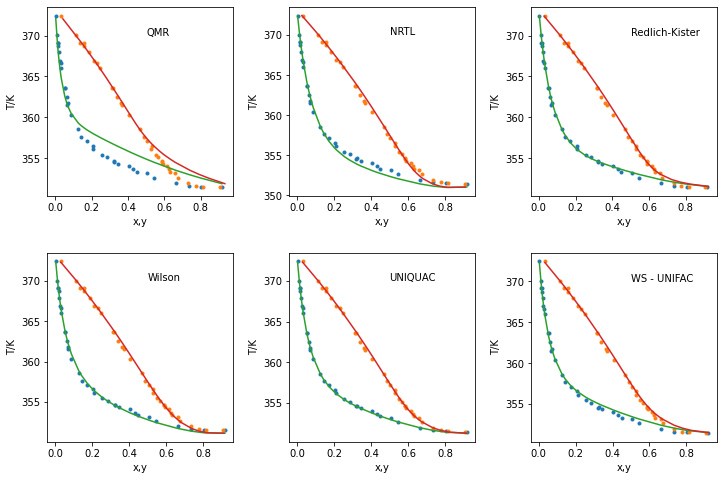

In [16]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(12,8))
fig.subplots_adjust(hspace=0.3, wspace=0.3)

ax=fig.add_subplot(231)
ax.plot(Xexp[0], Texp,'.', Yexp[0], Texp,'.')
ax.plot(Xexp[0], Tkij, Ykij[0], Tkij)
ax.set_xlabel('x,y')
ax.set_ylabel('T/K')
ax.text(0.5, 370, 'QMR')

ax2 = fig.add_subplot(232)
ax2.plot(Xexp[0], Texp,'.', Yexp[0], Texp,'.')
ax2.plot(Xexp[0], Tnrtl, Ynrtl[0], Tnrtl)
ax2.set_xlabel('x,y')
ax2.set_ylabel('T/K')
ax2.text(0.5, 370, 'NRTL')

ax3 = fig.add_subplot(233)
ax3.plot(Xexp[0], Texp,'.', Yexp[0], Texp,'.')
ax3.plot(Xexp[0], Trk, Yrk[0], Trk)
ax3.set_xlabel('x,y')
ax3.set_ylabel('T/K')
ax3.text(0.5, 370, 'Redlich-Kister')

ax4 = fig.add_subplot(234)
ax4.plot(Xexp[0], Texp,'.', Yexp[0], Texp,'.')
ax4.plot(Xexp[0], Twilson, Ywilson[0], Twilson)
ax4.set_xlabel('x,y')
ax4.set_ylabel('T/K')
ax4.text(0.5, 370, 'Wilson')

ax5 = fig.add_subplot(235)
ax5.plot(Xexp[0], Texp,'.', Yexp[0], Texp,'.')
ax5.plot(Xexp[0], Tuniquac, Yuniquac[0], Tuniquac)
ax5.set_xlabel('x,y')
ax5.set_ylabel('T/K')
ax5.text(0.5, 370, 'UNIQUAC')

ax6 = fig.add_subplot(236)
ax6.plot(Xexp[0], Texp,'.', Yexp[0], Texp,'.')
ax6.plot(Xexp[0], Tws, Yws[0], Tws)
ax6.set_xlabel('x,y')
ax6.set_ylabel('T/K')
ax6.text(0.5, 370, 'WS - UNIFAC')

fig.show()

For further information please also check [official documentation](https://phasepy.readthedocs.io/), or just try:

```function?```